Given some RNA-seq alignments in BAM format and a isoform annotation table, find
the relevant equivalence classes, then estimate relative abundance of the isoforms.
You can learn about the BAM format here. You can use whatever library you choose to
parse the reads. In python, PySam is pretty good and in R Rsamtools is decent. If you are
using C/C++ there are official libraries as well (the actual BAM format is in C). If you are
a masochist, there is probably a Java implementation floating around.
You may implement the RSEM version[3] which has a likelihood in read-space or the
IsoEM/kallisto[1] version which is in equivalence class space. The kallisto version is a bit
more work because it will require computing equivalence classes from the reads, whereas theRSEM version can be done directly from the reads. The kallisto version will be drastically
faster than the RSEM version because of the reduced complexity of the likelihood function.
Please provide the transcript abundance table outputting the following formant:
transcript length effective length expected counts tpm
ENST000003679 1219 1019 517 2.93
The reads provided are single-end reads, so you will have to assume a fragment length
distribution. Treat it as N(200, 10) (with appropriate discretization/normalizations).
In your report you might plot some metric against the various iterations of the EM. Take
your pick.
Extra credit: output the final posterior probability of each read mapping to a particular
transcript.

steps:

- parse the rna fragment reads
- parse the transcriptome file

# Preparations: import packages & parse bam file

In [9]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

In [10]:
import itertools
from collections import Counter

In [11]:
from Bio import SeqIO

In [12]:
import pysam

In [13]:
alignments = []

In [14]:
def parse_bam(path):
    """
    given a path of a bam file, parse it
    """
    bamfile = pysam.AlignmentFile(path, "rb")
    return bamfile

In [15]:
bfile = parse_bam("aligned.bam")

In [16]:
bfile.count(until_eof=True)

6439964

# Fetch alignment results for each read

In [17]:
def get_read_IDs(bamfile):
    """
    get all unique reads' query_names from a file
    -----
    params:
        bamfile:
        i: how many reads to fetch
    return:
        unique_IDs: a list of query_names
        
    """
    read_IDs = []
    ID_iter = bamfile.fetch(until_eof=True)#get all read_IDs
    for r in ID_iter:
        read_IDs.append ( str(r.qname) )
        
    unique_IDs = np.unique(read_IDs)
    
    return unique_IDs

In [18]:
rids = get_read_IDs(parse_bam("aligned.bam"))

## Get Equivalence Class

In [21]:
def get_EC_count(bamfile, read_ids):
    """
    get equivalence class
    -----------
    params: 
        bamfile: a parsed bam
        read_IDs: a list of query_names 
    return:
        EC_count: a dict with key: equivalence class(tuple of transcript IDs); value: equivalence class count
    """
    #parse a bamfile
    #bamfile = pysam.AlignmentFile(path, "rb")#default bam file
    
    #build by index
    bam_indexed = pysam.IndexedReads(bamfile)
    bam_indexed.build()
    #get the alignment(multimapped) for each read, according to id
    EC_list = np.array([np.sort(np.array([x.reference_name for x in bam_indexed.find(u)])) for u in read_ids])
    
#     for u in unique_IDs:
#         print(u)
#         cur_aligned_transcipts = [x.reference_name for x in bam_indexed.find(u)]
#         EC_list.append(cur_aligned_transcipts)
    EC_count = Counter( map(tuple, EC_list) )# a dict with key as equivalent classes, value as class counts
    
    return EC_count

In [22]:
ec = get_EC_count(bfile, rids)

<ipython-input-21-0a8b22f9ab25>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  EC_list = np.array([np.sort(np.array([x.reference_name for x in bam_indexed.find(u)])) for u in read_ids])


In [23]:
len(ec)

13566

# Initial abundance calculation

### transcriptome informations:

In [24]:
transcriptomes = []
for record in SeqIO.parse("chr11_transcriptome.fasta", "fasta"):
    transcriptomes.append([record.id, len(record.seq)])

In [25]:
transcriptomes = dict(transcriptomes)

In [26]:
def get_initial_abundance(transcriptomes, EC):#E step actually
    """
    generate initial uniform abundance for each transcriptome
    ---------------------------------
    params:
        transcriptomes: a dict of key being transcript ID, value being transcript length
    return:
        abundance: a dict of uniformly setted abundance(with respect to length of the transcript) 
                    { key: transcript ID; value: abundance } 
    """
    #np.sum(df['occurence'])
    transcriptomes_count = len(transcriptomes)
    abundance = {}
    for i in transcriptomes:
        #print(i)
        abundance[i] = ( 1/len(transcriptomes) ) / transcriptomes[i] #i[1] is the length of the current isoform
    #print(abundance)
    #normalize with respect to length
    factor=1.0/sum(abundance.values())
    for k in abundance:
        abundance[k] = abundance[k]*factor
        
    return abundance

In [27]:
abu = get_initial_abundance(transcriptomes, ec)

In [32]:
len(abu)

7138

# Expectation Maximization Model

## expectation

In [33]:
def E_step(last_abundance , EC):
    """transcriptome
    ----------------
    params:
         last_abundance: a dict: key: transcriptome ID; value: abundance from last step
         EC: a dict: key: equivalent class; value: class count
    return:
        update: a dict: key: ec 
                        value: a dict of probability to be updated with 
                                    key: transcript; 
                                    value: probability within that ec 
                                    (each EC sums to 1) 
    
    """
    ##check if want to terminate
    update ={}
    for r in EC.keys(): #for each equivalence class
        cur_update = {}
        for t in r: # for 
            cur_update[t] = last_abundance[t]
                
        norm=1.0/sum(cur_update.values())#normalize within ec
        for k in cur_update:
            cur_update[k] = cur_update[k]*norm
            
        #append to update    
        update[r] = cur_update
        
        
    return update

## maximization

In [136]:
def M_step(update, transcriptome, EC):
    """
    maximization step: calculate new abundance based on given probability within each equivalence class 
                    for each transcriptome
    ---------
    param:
        update: a dict: key: ec (wqe, das, qwe)
                        value: a dict of probability with 
                                    key: transcript; {wqe: 09,das: 09, qwe04}
                                    value: probability within that ec 
                                    (each EC sums to 1) 
        transcriptome: a dict: key: transcriptome ID; value: length of the transcriptome reference
        
    return:
        new_abundance: a dict: key: transcriptome ID; value: updated abundance
    """
    new_abundance = {}
    for key in update.keys():#loop over the dict, key-> ec
        cur_update = update[key]# cur_update -> dict of current ec 
        for t in key: #t-> transcript
            if t not in new_abundance:
                new_abundance[t] = (cur_update[t]/ transcriptomes[t] )* EC[key]
            else:
                cur_new_abun = new_abundance[t] 
                new_abundance.update({t: ((cur_update[t]/ transcriptomes[t])* EC[key] + cur_new_abun) })
                
    #add ec count -added           
    
    #add fragment length factor:
    #print(new_abundance)
    
#     for n in new_abundance.keys(): -added
#         new_abundance[n] = new_abundance[n] / transcriptomes[n]
        
    #normalize updated abundance:
    nm=1.0/sum(new_abundance.values())#normalize within ec
    for ab in new_abundance:
        new_abundance[ab] = new_abundance[ab]*nm
        
    return new_abundance

## Run EM, generate graphs, output

In [170]:
def run_EM(transcriptomes, EC, steps = 10, verbose = 100):
    #updated_abundance = {}
    newest_abundance = {}
    #update
    init_data = get_initial_abundance(transcriptomes, EC)
    first_update = E_step(init_data, EC)
    #newest_abundance = {}
    
    s=0
    
    for step in range(steps+1):
        
        if step ==0:
            update = E_step(init_data, EC)
        else: 
            update = E_step(newest_abundance, EC)
        newest_abundance = M_step(update, transcriptomes, EC)
        
        if s %verbose == 0:
            print("current step:"+ str(s) )
            plot_EM(newest_abundance)
        s+=1
        #latest_abundance = new_abundance
        
    return newest_abundance

In [172]:
def plot_EM(abu):
    fig, ax = plt.subplots()
    ax.pie(abu.values(),

            #labels=pieLabels,

            #autopct='%1.2f',
           #autopct ='%1.1f%%',
            autopct=lambda p: format(p, '.2f') if p > 3 else None,
            normalize=True,
           
            startangle=90)

    # Aspect ratio - equal means pie is a circle

    ax.axis('equal')
    plt.show()

current step:0


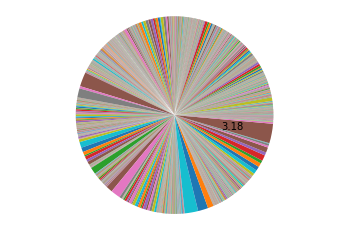

current step:20


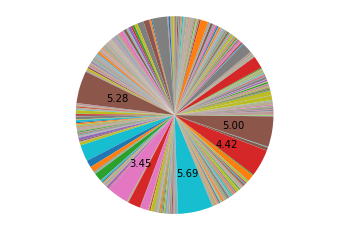

current step:40


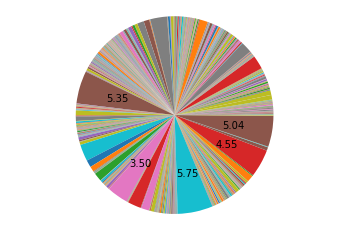

current step:60


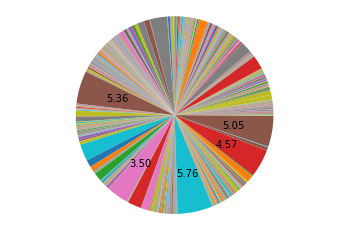

current step:80


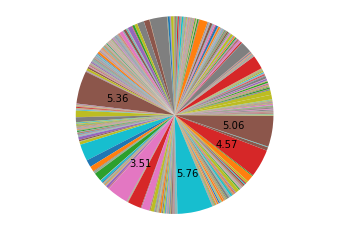

current step:100


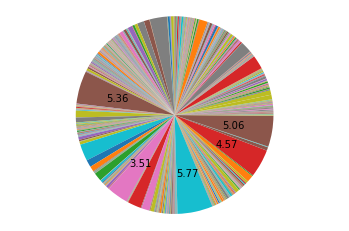

In [173]:
re = run_EM(transcriptomes, ec, steps = 100, verbose = 20)

## output result:

In [174]:
def make_output_file(raw_bamfile, result_abundance, transcriptomes, write_out = False):
    """
    params:
        raw_bamfile: a parsed raw bam file
        result_abundance:
        transcriptomes_df: contacts information about the transcript length, occurence
        write_out: if want quantified csv result
    """
    df = pd.DataFrame.from_dict(result_abundance, orient = 'index')
    df = df.reset_index()
    
    transcriptomes_df = pd.DataFrame.from_dict(transcriptomes, orient = 'index')
    transcriptomes_df =transcriptomes_df.reset_index()
    transcriptomes_df = transcriptomes_df.rename(columns={"index":"ID", 0: "length"})
    
    df = df.rename(columns={"index":"ID", 0: "abundance"})
    df = transcriptomes_df.merge(df, on = 'ID')
    
    
    df['effective length'] = abs(df['length'] - int(np.random.normal(200, 10) ) + 1 )
    #df['expected_counts'] = (transcriptomes_df['occurence'] * df['length']) / df['effective length']
    #raw_bamfile = parse_bam("aligned.bam")
    num_reads = raw_bamfile.count(until_eof=True)
    
    df['expected_counts'] = df['abundance']* num_reads* (df['length'] / df['effective length'])
    #print(num_reads)
    df['expected_counts'] = df['expected_counts'].astype(int)
    
    #df['TPM_intermediate_df'] = transcriptomes_df['occurence']/df['length']
    
    df['TPM_intermediate_df'] = df['abundance']* num_reads /df['length']
    
    
    df['TPM']= ( df['TPM_intermediate_df'] / np.sum(df['TPM_intermediate_df']) ) *1000000 
    df['TPM'] = df['TPM'].round(2)
    
    df = df.rename(columns = {"ID": "transcript",})
    df = df.drop(columns=[#'occurence',
                          'abundance',
                          #'abundance',
                          'TPM_intermediate_df'])
    #df = df.sort_values(by=['TPM'])
    if write_out:
        df.to_csv('EM_quantified.csv')
        
    return df

In [175]:
o = make_output_file(parse_bam("aligned.bam"), re, transcriptomes)

In [176]:
o

,transcript,length,effective length,expected_counts,TPM
0,ENST00000410108,637,415,2023,294.69
1,ENST00000325147,2916,2694,444,20.06
2,ENST00000382762,2792,2570,4118,193.33
3,ENST00000529614,560,338,0,0.00
4,ENST00000332865,533,311,0,0.00
...,...,...,...,...,...
6319,ENST00000339772,3152,2930,31,1.34
6320,ENST00000535456,3251,3029,1,0.06
6321,ENST00000392580,3522,3300,0,0.00
6322,ENST00000312527,3976,3754,0,0.00


## Drafts

In [165]:
aligned = aligned.rename(columns={"index":"ID", 0: "occurence"})

In [663]:
aligned[aligned['ID'] == 'ENST00000327804']

,ID,occurence


In [665]:
max(aligned['occurence'])

63018

In [182]:
#np.sum(init_data['occurence'])
init_dat_trail = init_data
init_dat_trail['ab'] = init_data['occurence'] / np.sum(init_data['occurence'])

In [183]:
init_dat_trail

,ID,length,occurence,ab
0,ENST00000410108,637,191,2.965855e-05
1,ENST00000325147,2916,1569,2.436349e-04
2,ENST00000382762,2792,1591,2.470511e-04
3,ENST00000529614,560,243,3.773313e-05
4,ENST00000332865,533,258,4.006234e-05
...,...,...,...,...
6319,ENST00000339772,3152,13,2.018645e-06
6320,ENST00000535456,3251,13,2.018645e-06
6321,ENST00000392580,3522,3,4.658411e-07
6322,ENST00000312527,3976,3,4.658411e-07


In [371]:
ecd = pd.DataFrame.from_dict(ec,orient = 'index')

In [372]:
ecd = ecd.reset_index()

In [375]:
ec_df = ecd.rename(columns={ 'index' :"EC", 0: "EC_count"})

In [376]:
ec_df

,EC,EC_count
0,"(ENST00000325147, ENST00000332865, ENST0000038...",55
1,"(ENST00000410108,)",87
2,"(ENST00000325147, ENST00000382762)",1262
3,"(ENST00000328221, ENST00000399808, ENST0000039...",7
4,"(ENST00000300737, ENST00000526596, ENST0000061...",816
...,...,...
13561,"(ENST00000422465, ENST00000525690, ENST0000052...",1
13562,"(ENST00000278572, ENST00000422465, ENST0000052...",2
13563,"(ENST00000526608,)",6
13564,"(ENST00000527273,)",3


In [346]:
transcriptome_df = pd.DataFrame.from_dict(transcriptomes)

In [347]:
transcriptome_df = transcriptome_df.rename(columns={0:"ID", 1: "length"})

In [348]:
transcriptome_df

,ID,length
0,ENST00000410108,637
1,ENST00000325147,2916
2,ENST00000382762,2792
3,ENST00000529614,560
4,ENST00000332865,533
...,...,...
7133,ENST00000339772,3152
7134,ENST00000535456,3251
7135,ENST00000392580,3522
7136,ENST00000312527,3976


In [396]:
len(transcriptomes)

7138

In [489]:
re = run_EM(transcriptomes, ec, steps = 20, verbose = 100)

In [493]:
len(re.keys() )

6324

TypeError: pie() got an unexpected keyword argument 'cmap'

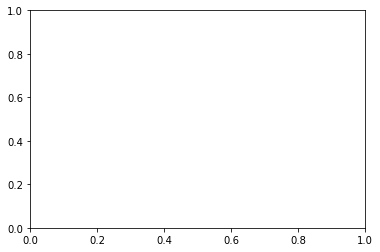

In [185]:
fig, ax = plt.subplots()
plt.pie(re.values(),

        #labels=pieLabels,

        autopct='%1.2f',
        cmap='GnBu',
        startangle=90)

# Aspect ratio - equal means pie is a circle

ax.axis('equal')
plt.show()

,transcript,length,abundance,effective length,expected_counts,TPM_intermediate_df,TPM
0,ENST00000410108,637,9.115317e-268,438,8.537300e-261,9.215433e-264,0.0
4221,ENST00000541951,1383,1.896416e-259,1184,1.426552e-252,8.830696e-256,0.0
4220,ENST00000537289,582,1.885828e-269,383,1.845482e-262,2.086712e-265,0.0
4219,ENST00000541455,1038,2.407134e-268,839,1.917870e-261,1.493435e-264,0.0
4218,ENST00000545127,922,1.861062e-266,723,1.528400e-259,1.299910e-262,0.0
...,...,...,...,...,...,...,...
2102,ENST00000399249,4217,2.883072e-274,4018,1.948644e-267,4.402865e-271,0.0
2101,ENST00000634938,658,6.410969e-270,459,5.918618e-263,6.274531e-266,0.0
2110,ENST00000531974,856,6.598389e-273,657,5.536429e-266,4.964180e-269,0.0
6323,ENST00000524765,5737,7.417684e-274,5538,4.948615e-267,8.326585e-271,0.0


In [64]:
o [o['transcript'] == 'ENST00000327804'] 

,transcript,length,abundance,effective length,expected_counts,TPM_intermediate_df,TPM


In [98]:
max(o["abundance"])

1.0

In [66]:
o.iloc[o['abundance'].idxmax() ]

transcript             ENST00000378024
length                           18761
abundance                            1
effective length                 18562
expected_counts            6.50901e+06
TPM_intermediate_df            343.263
TPM                              1e+06
Name: 2732, dtype: object

In [ ]:
transcriptomes_data

#### get transcripts with length

In [43]:
transcriptomes

{'ENST00000410108': 637,
 'ENST00000325147': 2916,
 'ENST00000382762': 2792,
 'ENST00000529614': 560,
 'ENST00000332865': 533,
 'ENST00000486280': 665,
 'ENST00000342878': 435,
 'ENST00000325113': 1284,
 'ENST00000525282': 764,
 'ENST00000526104': 3506,
 'ENST00000325207': 2702,
 'ENST00000528357': 500,
 'ENST00000526982': 965,
 'ENST00000530889': 563,
 'ENST00000626818': 159,
 'ENST00000527696': 2565,
 'ENST00000527468': 571,
 'ENST00000527728': 859,
 'ENST00000524854': 649,
 'ENST00000529275': 440,
 'ENST00000382743': 2882,
 'ENST00000529937': 2627,
 'ENST00000532837': 1588,
 'ENST00000525319': 1475,
 'ENST00000524564': 1395,
 'ENST00000532956': 1235,
 'ENST00000529382': 1225,
 'ENST00000526854': 785,
 'ENST00000529055': 779,
 'ENST00000530067': 681,
 'ENST00000528469': 763,
 'ENST00000525776': 365,
 'ENST00000525237': 430,
 'ENST00000529372': 612,
 'ENST00000532097': 1589,
 'ENST00000431206': 1591,
 'ENST00000528906': 858,
 'ENST00000525665': 1632,
 'ENST00000352303': 1427,
 'ENST00